# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

>**Exercise 8.1:** Define needed transforms for training images and testing images.

In [27]:
## Exercise 8.1:

data_dir = '/home/jovyan/work/cat_dog/Cat_Dog_data/' ## TODO: set correct path here

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(244),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(244),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [28]:
# Ladataan koulutettu densenet-verkko käyttöön
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [29]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Määritelläään luokitin kuvien, jossa kaksi luokkaa    
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [5]:
import time

In [6]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 1.544 seconds
Device = cuda; Time per batch: 0.010 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise 8.2:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [30]:
## Exercise 8.2:
## TODO: Use a pretrained model to classify the cat and dog images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

# Virhefunktion laskemiseen NLLLoss(), koska käytämme logsoftmaxia
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

# Malli CUDA-laskentaan
model.to(device);

In [44]:
# Luodaan listat virheille 
traininglosses = []
testinglosses = []
testaccuracy = []
totalsteps = []
# Valitaan yksi koulutuskierros
# mini-Batchin koko on 64 kuvaa
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Määritetään laskenta CUDA:lle
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Nollataan gradientit
        optimizer.zero_grad()
        
        # Ajetaan data mallin läpi
        logps = model.forward(inputs)
        
        # Lasketaan loss-arvo vertaamalla outputtia ja labeleita
        loss = criterion(logps, labels)
        
        # Lasketaan gradientit jokaiselle muuttujalla takaperin (w')
        loss.backward()
        
        # Ja päivitetään uudet arvot (w)
        optimizer.step()
        
        # Kokonaisvirhe
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            # Asetetaan malli evaluointi (arviointi) tilaan
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    # Yhtäsuuruuden tarkistaminen
                    # Tarkastetaan siis ennustetta ja labelia
                    # Paluttaa arvon 1 (True), jos ennuste ja luokka on oikein
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Lisätään virheet listoihin 
            traininglosses.append(running_loss/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(accuracy/len(testloader))
            totalsteps.append(steps)
            
            print(f"Device {device}.."
                  f"Epoch {epoch+1}/{epochs}.. "
                  f"Step {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            
            # Nollataan kokonaisvirhe 
            running_loss = 0
            
            # Malli harjoitustilaan
            model.train()

Device cuda..Epoch 1/1.. Step 5.. Train loss: 0.412.. Test loss: 0.231.. Test accuracy: 0.929
Device cuda..Epoch 1/1.. Step 10.. Train loss: 0.481.. Test loss: 0.359.. Test accuracy: 0.841
Device cuda..Epoch 1/1.. Step 15.. Train loss: 0.258.. Test loss: 0.294.. Test accuracy: 0.861
Device cuda..Epoch 1/1.. Step 20.. Train loss: 0.210.. Test loss: 0.158.. Test accuracy: 0.939
Device cuda..Epoch 1/1.. Step 25.. Train loss: 0.155.. Test loss: 0.153.. Test accuracy: 0.936
Device cuda..Epoch 1/1.. Step 30.. Train loss: 0.154.. Test loss: 0.147.. Test accuracy: 0.936
Device cuda..Epoch 1/1.. Step 35.. Train loss: 0.147.. Test loss: 0.138.. Test accuracy: 0.937
Device cuda..Epoch 1/1.. Step 40.. Train loss: 0.168.. Test loss: 0.146.. Test accuracy: 0.934
Device cuda..Epoch 1/1.. Step 45.. Train loss: 0.178.. Test loss: 0.155.. Test accuracy: 0.928
Device cuda..Epoch 1/1.. Step 50.. Train loss: 0.230.. Test loss: 0.167.. Test accuracy: 0.922
Device cuda..Epoch 1/1.. Step 55.. Train loss: 0.14

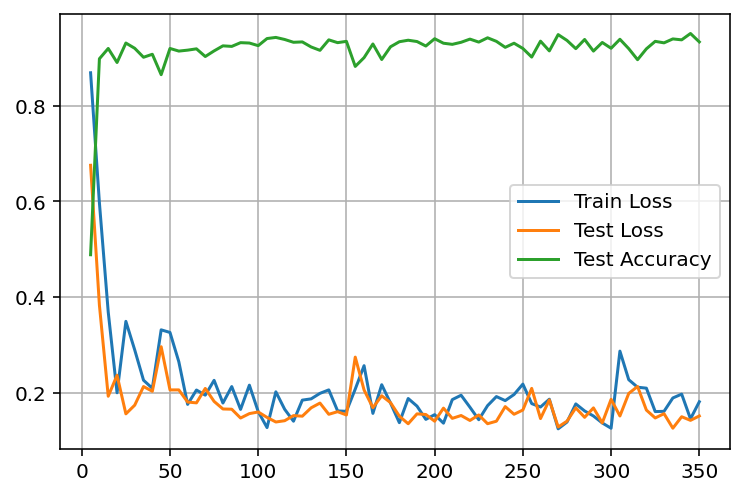

In [9]:
from matplotlib import pyplot as plt
# Plotataan mallin tarkkuus, harjoitusvirhe sekä testi/validointi -virhe
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

But still the network makes mistakes... 

>**Exercise 8.3:** Print 8 pictures of errors in dog/cat -classification. 


Wrong predictions:
 [1, 1, 1, 1, 1, 1, 1, 1]

Right labels:
 [0, 0, 0, 0, 0, 0, 0, 0]



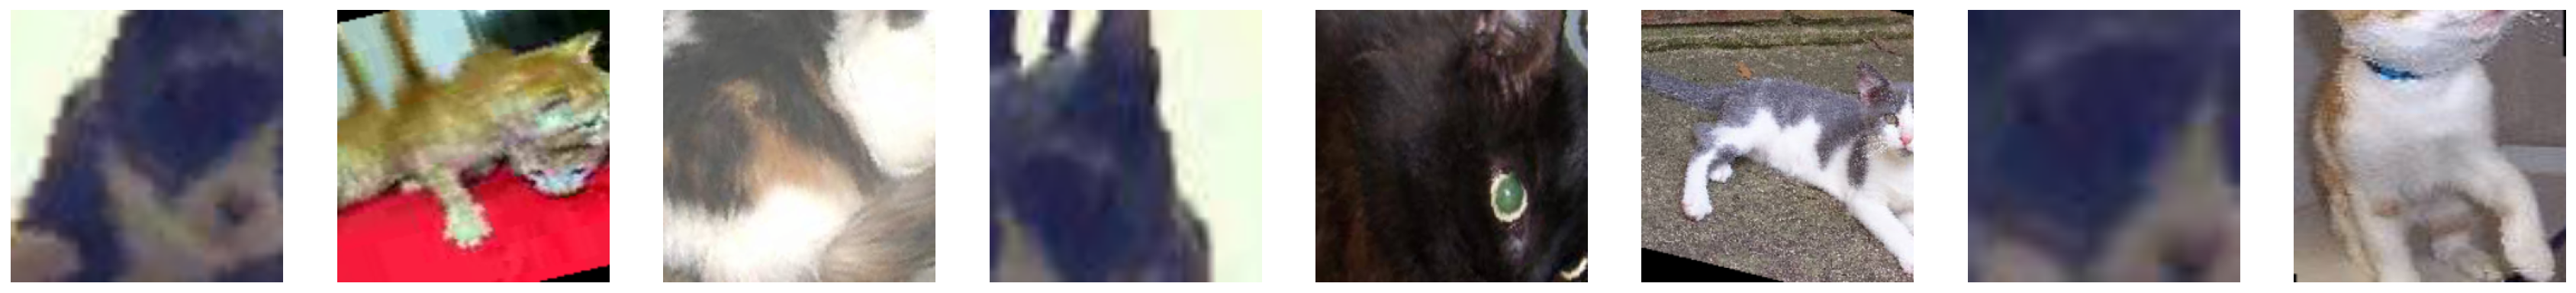

In [164]:
## Exercise 8.3:
## TODO: Print 8 pictures of errors in dog/cat -classification. 

wrong_labels = []
images = []
right_labels = []

# Ilman looppia emme välttämättä saa kahdeksaa kuvaa kasaan
while len(wrong_labels) < 8:

    inputs, labels = next(iter(testloader))
    inputs, labels = inputs.to(device), labels.to(device)
    model.to(device)
    ps = torch.exp(model(inputs))

    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)

    # Käydään läpi equals, joka sisältää 1 ja 0 -arvoja (True/False)
    for index, value in enumerate(equals):
        # Jossa meitä nyt kiinnostaa Falset
        # False, kun ennuste ja oikea label eivät täsmää
        if value == False:
            # Lisätään listaan oikean labelin indexi
            right_labels.append(labels[index].item())         
            # input-tensorit ovat nyt GPU-muistissa, joten ne täytyy siirtää takaisin muistiin....
            # ... johon prosessori pääsee käsiksi. 
            # Joten tarvitaan .cpu() -metodia
            # Lisätään listaan kuva, jossa ennuste meni pieleen
            images.append(inputs[index].cpu())
            # Lisätään listaan verkon antaman ennusteen indexi
            wrong_labels.append(top_class[index].item())

#helper.imshow(images[0], normalize=True)

# for image in images:
#     helper.imshow(image, normalize=True)


print("Wrong predictions:\n", wrong_labels)
print("\nRight labels:\n", right_labels)
print()

# Printataan 8 kpl kuvia
fig, axes = plt.subplots(figsize=(30,10), ncols=8)
for ii in range(8):
    ax = axes[ii]
    # Asetetaan normalize Trueksi, jotta kuvista itse voisi saada selvää
    helper.imshow(images[ii], ax=ax, normalize=True)

### Kertausta:

In [154]:
# Tästä emme näe, minkä indexin tensorit saavat arvon False
for i in equals:
    if i == False:
        print(i) 

tensor([False], device='cuda:0')
tensor([False], device='cuda:0')
tensor([False], device='cuda:0')
tensor([False], device='cuda:0')


In [155]:
# enumeratella myös indexit näkyviin
for index, i in enumerate(equals):
    if i == False:
        print(index,i.item()) # Ja item() -metodi "purkaa" tensorin sisällön siistimpään muotoon

11 False
13 False
17 False
56 False


## Reflection

Answer briefly following questions (in English or Finnish):
- What is CUDA?
- Why GPU is faster than CPU?
- How many pre-trained image network can you find from torchvision models?
- What kind of pictures network mislabels? Are those still easy for a human to classify?




*Your answers here...*

### What is CUDA?

CUDA on Nvidian kehittämä alusta ja ohjelmointirajapinta GPU-laskentaan, jossa laskenta suoritetaan näytönohjaimen prosessorilla eli grafiikkasuorittimella.

### Why GPU is faster than CPU?

Näytönohjaimen grafiikkasuorittimet ovat normaaliin prosessoriin verrattuna paljon tehokkaampia rinnakkaislaskennassa. Esimerkiksi joissain algoritmeissä GPU voi olla jopa 10-100 kertaa nopeampi. GPU:n suorituskyky perustuu siihen, että sillä on paljon yksinkertaisia suorittimia rinnakkain. 

### How many pre-trained image network can you find from torchvision models?

12 kpl :
- `resnet18 = models.resnet18(pretrained=True)`              
- `alexnet = models.alexnet(pretrained=True)`
- `squeezenet = models.squeezenet1_0(pretrained=True)`
- `vgg16 = models.vgg16(pretrained=True)`
- `densenet = models.densenet161(pretrained=True)`
- `inception = models.inception_v3(pretrained=True)`
- `googlenet = models.googlenet(pretrained=True)`
- `shufflenet = models.shufflenet_v2_x1_0(pretrained=True)`
- `mobilenet = models.mobilenet_v2(pretrained=True)`
- `resnext50_32x4d = models.resnext50_32x4d(pretrained=True)`
- `wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)`
- `mnasnet = models.mnasnet1_0(pretrained=True)`

### What kind of pictures network mislabels? Are those still easy for a human to classify?

Kissojen kanssa. Osasta kuvista tunnistaa kyllä kissan, muttei läheskään kaikista, sillä osa kuvista jotka ovat virheellisesti tunnistettu, ovat todella epäselviä. Batchissani oli myös eräs kuva, jossa oli kissa sekä koira, mutta sen oikealabel oli kuitenkin kissa ja verkko ennuste sen koiraksi.

<img src="mypictures/dogcat.png" width=500px>